# Simple Plotting


In [ ]:
RESULTS_PATH = "../../your_sweep_path/default"

PLOT_ALL_SEEDS = False
# Full sweep
MODELS_TO_PLOT = ["gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl", "Qwen/Qwen-1_8B", "Qwen/Qwen-7B", "Qwen/Qwen-14B"]
# Minimal sweep
# MODELS_TO_PLOT = ["gpt2", "gpt2-medium", "gpt2-large"]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from IPython.display import display

import os
import glob
import json

In [ ]:
records = []
for result_filename in glob.glob(os.path.join(RESULTS_PATH, "**/results_summary.json"), recursive=True):
    config_file = os.path.join("/".join(result_filename.split("/")[:-1]), "config.json")
    config = json.load(open(config_file, "r"))
    if config["model_size"] not in MODELS_TO_PLOT:
        continue
    if 'seed' not in config:
        config['seed'] = 0
    record = config.copy()
    if 'weak_model' in config:
        for k in record['weak_model']:
            if k == 'model_size':
                assert record['weak_model'][k] == record['weak_model_size']
            record['weak_' + k] = record['weak_model'][k]
        del record['weak_model']
    record.update(json.load(open(result_filename)))
    records.append(record)

df = pd.DataFrame.from_records(records).sort_values(['ds_name', 'model_size'])

In [ ]:
datasets = df.ds_name.unique()
for dataset in datasets:
    cur_df = df[(df.ds_name == dataset)].copy()
    base_accuracies = cur_df[cur_df['weak_model_size'].isna()].groupby('model_size').agg({'accuracy': 'mean', 'seed': 'count'}).sort_values('accuracy')
    base_accuracy_lookup = base_accuracies['accuracy'].to_dict()
    base_accuracies = base_accuracies.reset_index()

    cur_df['strong_model_accuracy'] = cur_df['model_size'].apply(lambda x: base_accuracy_lookup[x])
    cur_df.loc[~cur_df['weak_model_size'].isna(), 'weak_model_accuracy'] = cur_df.loc[~cur_df['weak_model_size'].isna(), 'weak_model_size'].apply(lambda x: base_accuracy_lookup[x])

    # Exclude cases where the weak model is better than the strong model from PGR calculation.
    valid_pgr_index = (
        (~cur_df['weak_model_size'].isna()) & 
        (cur_df['weak_model_size'] != cur_df['model_size']) & 
        (cur_df['strong_model_accuracy'] > cur_df['weak_model_accuracy'])
    )
    cur_df.loc[valid_pgr_index, 'pgr'] = (cur_df.loc[valid_pgr_index, 'accuracy'] - cur_df.loc[valid_pgr_index, 'weak_model_accuracy']) / (cur_df.loc[valid_pgr_index, 'strong_model_accuracy'] - cur_df.loc[valid_pgr_index, 'weak_model_accuracy'])

    cur_df.loc[cur_df['weak_model_size'].isna(), "weak_model_size"] = "ground truth"

    for seed in [None] + (sorted(cur_df['seed'].unique().tolist()) if PLOT_ALL_SEEDS else []):
        plot_df = cur_df.copy().sort_values(['strong_model_accuracy']).sort_values(['loss'], ascending=False)
        if seed is not None:
            plot_df = plot_df[plot_df['seed'] == seed]

        print(f"Dataset: {dataset} (seed: {seed})")

        pgr_results = plot_df[~plot_df['pgr'].isna()].groupby(['loss']).aggregate({"pgr": "median"})

        palette = sns.color_palette('colorblind', n_colors=len(plot_df['weak_model_size'].unique()) - 1)
        color_dict = {model: ("black" if model == 'ground truth' else palette.pop()) for model in plot_df['weak_model_size'].unique()}

        sns.lineplot(data=plot_df, x='strong_model_accuracy', y='accuracy', hue='weak_model_size', style='loss', markers=True, palette=color_dict)
        pd.plotting.table(plt.gca(), pgr_results.round(4), loc='lower right', colWidths=[0.1, 0.1], cellLoc='center', rowLoc='center')
        plt.xticks(ticks=base_accuracies['accuracy'], labels=[f"{e} ({base_accuracy_lookup[e]:.4f})" for e in base_accuracies['model_size']], rotation=90)
        plt.title(f"Dataset: {dataset} (seed: {seed})")
        plt.legend(loc='upper left')
        suffix = ""
        if seed is not None:
            suffix = f"_{seed}"
        plt.savefig(f"{dataset.replace('/', '-')}{suffix}.png", dpi=300, bbox_inches='tight')
        plt.show()

# Calibration w.r.t. the soft labels

In [85]:
import os
from datasets import load_from_disk
import numpy as np

strong_path = "../results/conf_disagree/bs=32-dn=sciq_with_supp-ge=3-lp=0-l=xent-l=4e-05-ls=cosi_anne-mc=512-ms=Qwen1.5-0.5B-ntd=500-ntd=4300-ntd=4300-o=adam-s=0-twd=0"
w2s_path = "../results/conf_disagree/bs=32-dn=sciq_with_supp-lp=0-l=kl-l=2e-05-ls=cosi_anne-mc=512-ms=Qwen1.5-0.5B-ntd=500-ntd=4300-ntd=4300-o=adam-s=0-see=15-twd=0-we=2-wlf=0.5-wms=opt-350m"
eval_results_paths = [p for p in os.listdir(w2s_path) if p.startswith("eval_results") and p[-1].isdigit()]
eval_results_paths.sort(key=lambda x: int(x.split("_")[-1]))

# TODO: exclude datapoints where the strong model gets it wrong even when finetuned on gt
# TODO: alternatively compare side-by-side with gt finetuning

weak_soft_labels = None
gt_labels = None
pred_probs = []
for p in eval_results_paths:
    eval_results = load_from_disk(os.path.join(w2s_path, p)).with_format("numpy")
    if weak_soft_labels is None:
        weak_soft_labels = eval_results['weak_soft_label'][:, 1]  # type: ignore
    else:
        assert np.all(weak_soft_labels == eval_results['weak_soft_label'][:, 1])  # type: ignore
    if gt_labels is None:
        gt_labels = eval_results['soft_label'][:, 1]  # type: ignore
    else:
        assert np.all(gt_labels == eval_results['soft_label'][:, 1])  # type: ignore
    pred_probs.append(eval_results['soft_pred'][:, 1])  # type: ignore

weak_soft_labels = np.array(weak_soft_labels)
pred_probs = np.array(pred_probs)
gt_labels = np.array(gt_labels)
weak_soft_labels.shape, pred_probs.shape, gt_labels.shape

((464,), (17, 464), (464,))

In [86]:
import plotly.graph_objs as go
import numpy as np

n_time_steps = len(pred_probs)
# Create base figure
fig = go.Figure(
    data=[go.Scatter(x=pred_probs[0], y=weak_soft_labels, mode='markers',  
                     marker=dict(color=gt_labels, colorscale='Viridis', colorbar=dict(title='GT Label')))],
    layout=go.Layout(
        title="Soft Labels Over Time",
        xaxis=dict(range=[0, 1], title="Strong student predicted probability"),
        yaxis=dict(range=[0, 1], title="Weak supervisor soft label"),
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, {"frame": {"duration": 700, "redraw": True}, "fromcurrent": True}]),
                    dict(label="Pause",
                         method="animate",
                         args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}])
                    ])]
    ),
    frames=[go.Frame(data=[go.Scatter(x=pred_probs[i], y=weak_soft_labels, mode='markers',
                                        marker=dict(color=gt_labels, colorscale='Viridis', colorbar=dict(title='GT Label')))],
                         name=str(i))
            for i in range(1, n_time_steps)]
)

# Add axis titles
fig.update_layout(xaxis_title="Strong student predicted probability", yaxis_title="Weak supervisor soft label", height=800, width=900)


# Show animation
fig.show()

# Get gradients per example

In [103]:
strong_eval_results_path = os.path.join(strong_path, "eval_results_final")
final_eval_results_path = os.path.join(w2s_path, "eval_results_final")
final_eval_results = load_from_disk(final_eval_results_path)
strong_eval_results = load_from_disk(strong_eval_results_path)
print(len(final_eval_results), len(strong_eval_results))
assert np.all(np.array(final_eval_results['id']) == np.array(strong_eval_results['id']))
final_eval_results = final_eval_results.add_column("strong_soft_pred", strong_eval_results['soft_pred'])  # type: ignore
final_eval_results = final_eval_results.add_column("strong_hard_pred", strong_eval_results['hard_pred'])  # type: ignore
final_eval_results = final_eval_results.with_format("torch")

464 464


In [104]:
import json
from tqdm.auto import tqdm

import torch

from weak_to_strong.datasets import load_and_process_dataset, tokenize_dataset
from weak_to_strong.config import ModelConfig, MODELS_DICT, LOSS_DICT
from weak_to_strong.model import TransformerWithHead
from weak_to_strong.common import get_tokenizer, to_batch

config = json.load(open(os.path.join(w2s_path, "config.json"), "r"))
model_name = config["model_size"]

In [94]:
use_lm_head = "choice_input_ids" in final_eval_results.column_names

model_config = ModelConfig(**MODELS_DICT[model_name])
model = TransformerWithHead.from_pretrained(  # type: ignore
            model_config.name,
            lora_modules=model_config.lora_modules,
            use_lm_head=use_lm_head,
            num_labels=2,
            linear_probe=config["linear_probe"],
            **model_config.custom_kwargs,
        ).cuda()

loss_fn = LOSS_DICT[config["loss"]]

Using LoraModel on modules ['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj']


In [95]:
d_proj = 2048  # TODO increase
model_n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

torch.manual_seed(0)  # ensure that our projection is the same across runs and examples
proj_basis_indices = torch.randint(0, model_n_params, (d_proj,))
proj_grads = torch.zeros((len(final_eval_results), d_proj), device=model.device)
for i, batch in tqdm(enumerate(to_batch(final_eval_results, batch_size=1))):
    input_ids = torch.nn.utils.rnn.pad_sequence(
                [ex for ex in batch["input_ids"]], batch_first=True
        ).to(model.device)
    label = batch["weak_soft_label"].to(model.device)
            
    logits = model(
                    input_ids, choice_input_ids=batch.get("choice_input_ids")
        )
        
    loss = loss_fn(logits, label, step_frac=0)
    loss.backward()

    # get grad in a vector
    # grad = torch.cat([p.grad.clone().detach().flatten() for p in model.parameters() if p.requires_grad])
    # project onto random direction
    # proj_grads[i] = grad[proj_basis_indices]
    proj_grads[i] = torch.cat([p.grad.clone().detach().flatten() for p in model.score.parameters() if p.requires_grad])

    # zero out grads
    model.zero_grad()

464it [00:46,  9.95it/s]


In [96]:
proj_grads_normalized = proj_grads / proj_grads.norm(dim=1, keepdim=True)

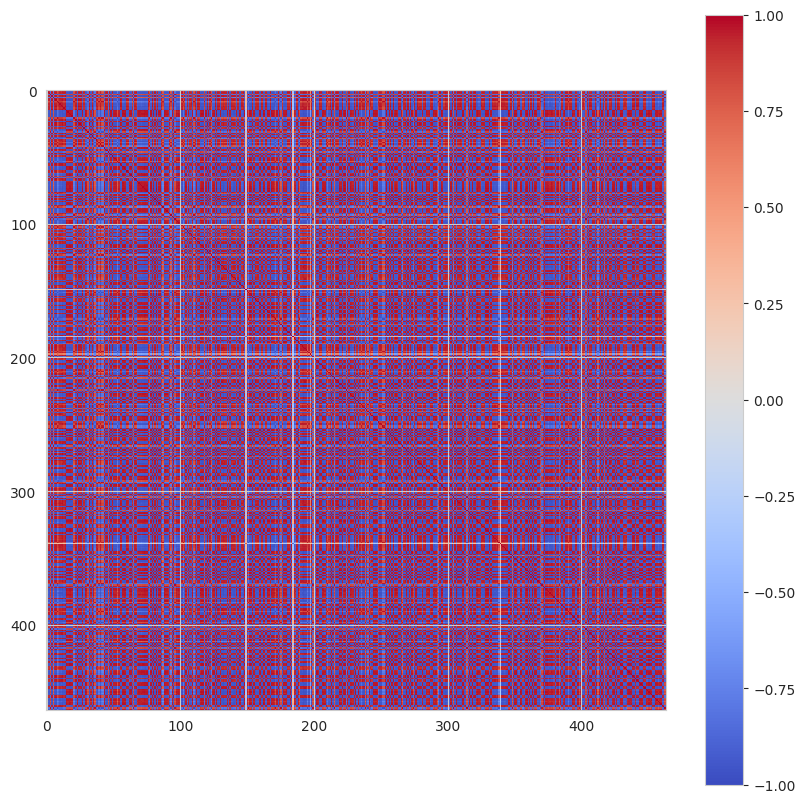

In [97]:
import matplotlib.pyplot as plt

similarity = proj_grads_normalized @ proj_grads_normalized.T
plt.figure(figsize=(10, 10))
plt.imshow(similarity.cpu().numpy(), vmin=-1, vmax=1, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.show()

In [98]:
# create two clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(proj_grads_normalized.cpu().numpy())
c1, c2 = proj_grads_normalized[kmeans.labels_ == 0], proj_grads_normalized[kmeans.labels_ == 1]

/mnt/ssd-1/alexm/miniconda3/envs/w2s/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



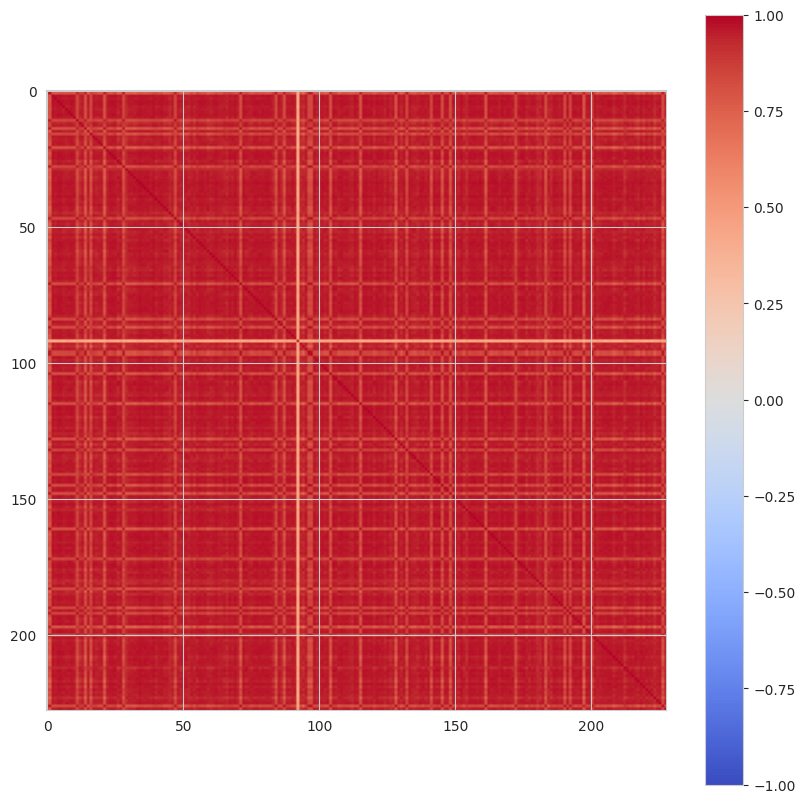

In [100]:
c = c2
similarity = c1 @ c1.T
plt.figure(figsize=(10, 10))
plt.imshow(similarity.cpu().numpy(), vmin=-1, vmax=1, cmap='coolwarm')
plt.colorbar()
plt.show()

In [111]:
soft_labels = np.array(final_eval_results["soft_label"])[:, 1]
weak_soft_labels = np.array(final_eval_results["weak_soft_label"])[:, 1]
strong_soft_preds = np.array(final_eval_results["strong_soft_pred"])[:, 1]
w2s_soft_preds = np.array(final_eval_results["soft_pred"])[:, 1]

weak_error = (weak_soft_labels - soft_labels)
weak_diff_from_strong = (weak_soft_labels - strong_soft_preds)


array([0.66796875, 0.5234375 , 0.9609375 , 0.7890625 , 0.9375    ,
       0.9453125 , 0.91796875, 0.95703125, 0.97265625, 0.96484375,
       0.97265625, 0.69140625, 0.95703125, 0.96484375, 0.9375    ,
       0.96875   , 0.94921875, 0.8203125 , 0.62890625, 0.90625   ,
       0.96484375, 0.65625   , 0.9296875 , 0.9765625 , 0.94921875,
       0.82421875, 0.96875   , 0.96484375, 0.71484375, 0.8671875 ,
       0.85546875, 0.97265625, 0.9453125 , 0.97265625, 0.9375    ,
       0.87890625, 0.91796875, 0.82421875, 0.9375    , 0.97265625,
       0.8046875 , 0.87890625, 0.9375    , 0.8515625 , 0.97265625,
       0.87890625, 0.87109375, 0.52734375, 0.96875   , 0.9609375 ,
       0.93359375, 0.9453125 , 0.96484375, 0.94921875, 0.9609375 ,
       0.96875   , 0.953125  , 0.90625   , 0.91796875, 0.95703125,
       0.9140625 , 0.91015625, 0.93359375, 0.953125  , 0.81640625,
       0.96484375, 0.9140625 , 0.93359375, 0.7109375 , 0.9765625 ,
       0.859375  , 0.81640625, 0.98046875, 0.96875   , 0.96484

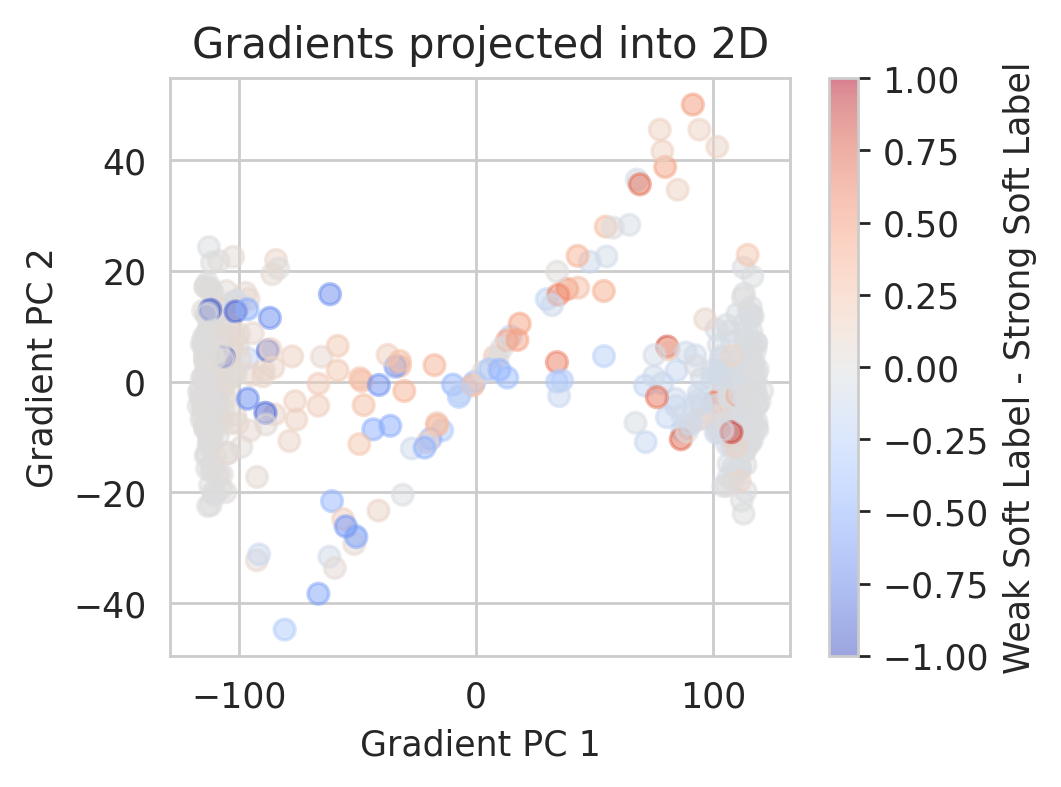

In [117]:
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_style('whitegrid')

# project gradients into 2D

use_normalized = False
compare_to_gt = False
mat = proj_grads_normalized if use_normalized else proj_grads
pca = PCA(n_components=10)
proj_2d = pca.fit_transform(mat.cpu().numpy())
plt.figure(figsize=(4, 3), dpi=250)
plt.scatter(proj_2d[:, 0], proj_2d[:, 1], c=weak_error if compare_to_gt else weak_diff_from_strong, cmap='coolwarm', alpha=0.5, marker='o', vmin=-1, vmax=1)
plt.colorbar(label=f"Weak Soft Label - {'GT' if compare_to_gt else 'Strong'} Soft Label")
plt.xlabel("Gradient PC 1")
plt.ylabel("Gradient PC 2")
plt.title("Normalized gradients projected into 2D" if use_normalized else "Gradients projected into 2D")
plt.show()